# Stanford AIMI MURA Dataset - Abnormal X-ray detection

## Background/Motivation
From the stanford website: 
MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal.

#### Original dataset/competition: https://stanfordmlgroup.github.io/competitions/mura/

## Summary Steps
- Downloaded the data separately. Includes images and labels.  This includes multiple X-ray categories
- Focussed on the XR-Wrist sub dataset (each sub data set is actually relatively small: <5K images/labels)
- Read the files and visualized (both positive and negative examples)
- Partitioned the data into training/test samples
- Tried 2 experiments:
   - Exp1: Tried training a convolutional neural network from scratch (no fine tuning) for detection
   - Exp2: Started with a pretrained model (Resnet-18).  Fine tuned this model for detection


## Summary Results
- Exp1
     - Exp1 results were not good. Significant overfitting. Test accuracy only slightly over 65%
     - <b>Overfitting<b> was somewhat expected as the training dataset had only ~3K Examples
     - Note that while the data set itself is huge (66 GB), each of the actual sub-categories (eg WRIST) has less than 5k images.
- Exp2 results were decent/good (and can be improved further)
    -  Started with Renset-18  
    -  <b> Achieved 82% test accuracy and with more finetuning should be able to improve more.  Was actually pleasantly surprised as the Resnet-18 was pretrained on Imagenet (natural images), and here we are testing on X-rays!! <b>


### Step1: Data Download
- Downloaded file seperately (From https://stanfordaimi.azurewebsites.net/datasets/)
- Stored locally in 'muramskxrays/MURA-v1.1/'

In [2]:
base_dir = 'muramskxrays/MURA-v1.1/'

### Step2: Read images and labels

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
def read_labels(csv_filename):
    label_dict = dict()
    infile = open(csv_filename, 'r')
    for line in infile:
        fields = line.rstrip().split(',')
        filename = fields[0]
        label = int(fields[1])
        if 'XR_WRIST' in filename:
            label_dict[filename] = label

    return label_dict

In [5]:
label_dict = read_labels(base_dir + 'train_labeled_studies.csv')

In [7]:
import os
import torch

def read_data(label_dict):
    tensor_list = list()
    label_list = list()

    for path in label_dict:
        directory_path = 'muramskxrays/' + path
        for filename in os.listdir(directory_path):
            if 'image1.png' not in filename:
                continue
            file_path = os.path.join(directory_path, filename)
            img = cv2.imread(file_path)
            img_tensor = torch.from_numpy(img/255)
            img_tensor = img_tensor.to(dtype=torch.float32)
            img_tensor = img_tensor.permute(2, 0, 1)

            tensor_list.append(img_tensor)
            label_list.append(label_dict[path])

    return tensor_list, label_list

In [8]:
tensor_list, label_list = read_data(label_dict)
#x = cv2.imread('muramskxrays/MURA-v1.1/train/XR_WRIST/patient06359/study1_positive/image1.png')

In [9]:
min_w = 128
min_h = 256
tensor_list_new = list()
for i in range(len(tensor_list)):
    c, h, w = tensor_list[i].shape
    # have to pick the middle portion
    h_start = int((h - min_h)/2)
    w_start = int((w - min_w)/2)

    img = tensor_list[i][:, h_start:(h_start + min_h), w_start:(w_start + min_w)]
    tensor_list_new.append(img)

tensor_list = tensor_list_new

### Visualize postive and negative samples

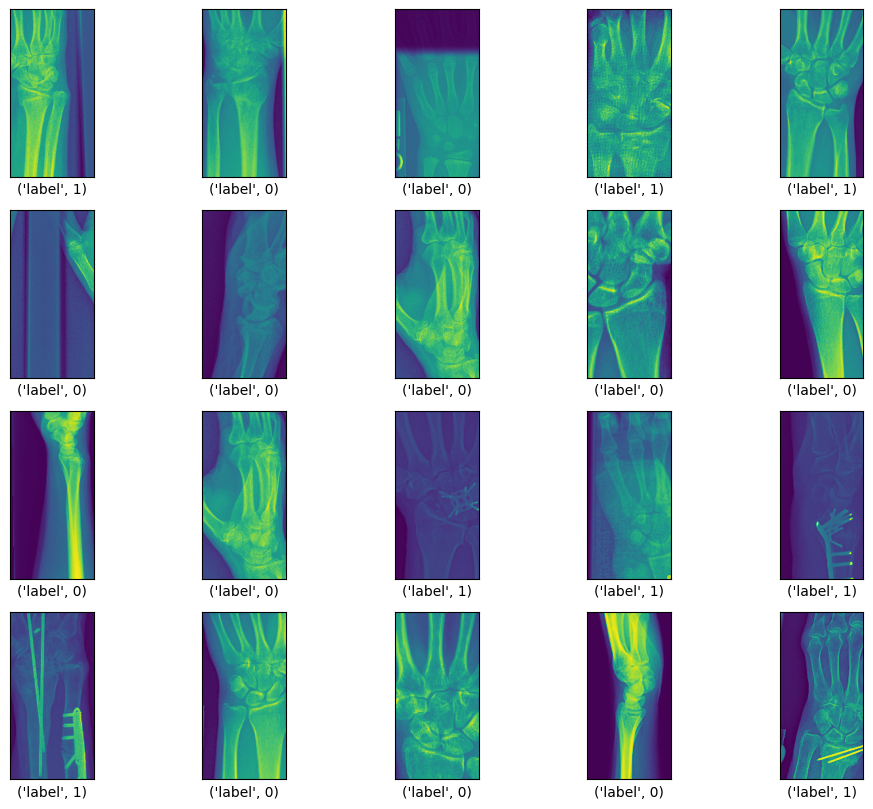

In [21]:
import random

plt.figure(figsize=(12, 10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    indx = random.randint(0, len(label_list) -1)
    plt.imshow(tensor_list[indx][0])
    label = "plot" + str(i)
    label = "label", label_list[indx]
    plt.xlabel(label)
plt.show()

### Split into Train/Test

In [23]:
import random

def create_train_test(tensor_list, labels):
    train_fraction = 0.9

    paired = list(zip(tensor_list, labels))

    # Shuffle the list of pairs
    random.shuffle(paired)

    # Calculate the split index (90% of the length of the paired list for training)
    split_idx = int(train_fraction * len(paired))

    # Split the paired list into training and testing lists
    train_pairs = paired[:split_idx]
    test_pairs = paired[split_idx:]

    # Separate the tensors and labels back into individual lists
    train_tensors, train_labels = zip(*train_pairs)
    test_tensors, test_labels = zip(*test_pairs)

    # Convert tuples back to lists if necessary

    train_x = torch.stack(train_tensors, dim=0)
    train_y = torch.tensor(train_labels)

    test_x = torch.stack(test_tensors, dim=0)
    test_y = torch.tensor(test_labels)

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = create_train_test(tensor_list, label_list)

## Exp1: Create a CNN network and train from scrach

In [25]:
from torch import nn

[n, c, image_h, image_w] = train_x.shape

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(c, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=1, stride=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(int(8 * image_h/4 * image_w/4), 100)
        self.rl = nn.ReLU()
        self.linear1 = nn.Linear(100, 10)
        self.linear2 = nn.Linear(10, 2)
                

    def forward(self, x):
        x = self.pool(self.rl(self.conv1(x)))
        x = self.pool(self.rl(self.conv2(x)))

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.rl(self.linear1(x))
        y = self.linear2(x)

        return y


model = NeuralNetwork().to('cpu')
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=100, bias=True)
  (rl): ReLU()
  (linear1): Linear(in_features=100, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)


In [27]:
def get_multi_class_acc(pred_y, label_y):
    tot_cnt = len(label_y)
    acc_cnt = 0
    for i in range(tot_cnt):
        indx = torch.argmax(pred_y[i])
        if indx == label_y[i]:
            acc_cnt += 1
    acc = float(100) * acc_cnt / tot_cnt
    #print("acc", acc)
    return acc

def get_batch(data_x, data_y):
    batch_size = 256
    ix = torch.randint(len(data_x), (batch_size,))
    x = torch.stack([data_x[i] for i in ix])
    y = torch.stack([data_y[i] for i in ix])
    #x, y = x.to(device), y.to(device)
    return x, y

In [28]:
train_x_batch, train_y_batch = get_batch(train_x, train_y)
pred = model(train_x_batch)

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


import time
model.train() #superflous, but documentation refers useful if doing dropout, etc
start_time = time.time()
base_desired_accuracy = 80
desired_accuracy = 90
num_iterations = 6000
for i in range(num_iterations):
    model.train()
    train_x_batch, train_y_batch = get_batch(train_x, train_y)
    pred = model(train_x_batch)
    loss = loss_fn(pred, train_y_batch)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # if i% 10 == 0
    if 1:
        model.eval()
        pred = model(train_x[0:100])
        train_loss = loss_fn(pred, train_y[0:100])
        train_acc = get_multi_class_acc(pred, train_y[0:100])
        
        pred = model(test_x)
        test_loss = loss_fn(pred, test_y)
        test_acc = get_multi_class_acc(pred, test_y)

        
        run_time = time.time() - start_time
        if i%100 == 0:
            print(i, "train_acc", train_acc, "test_acc", test_acc, "train_loss", train_loss.item(), "test_loss", test_loss.item())
            
        if test_acc > desired_accuracy:
            print("Achieved target test accuracy")
            break
        elif (train_acc - test_acc) > 10 and (test_acc > base_desired_accuracy):
            print("Reasonable test accuracy, terminating training as appears we are now overfitting")
            break
        elif (train_acc - test_acc) > 10 and (train_acc > 80):
            print("Heavy Overfitting, terminating training")
            break
        elif run_time > (3600 * 24): # 1 day
            print("Exceeded run time, breaking")

print("Training end: train_acc", train_acc, "test_acc", test_acc, "train_loss", train_loss.item(), "test_loss", test_loss.item())
end_time = time.time()
print("time taken", end_time - start_time)

0 train_acc 70.0 test_acc 65.89595375722543 train_loss 0.5522326827049255 test_loss 0.678992748260498
Heavy Overfitting, terminating training
Training end: train_acc 83.0 test_acc 60.982658959537574 train_loss 0.4991135895252228 test_loss 0.6918601989746094
time taken 197.2684142589569


## Exp2: Start with a pretrained Resnet-18 model and fine tune

In [31]:
import torch
import torchvision.models as models

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
num_classes = 2
num_ftrs = model.fc.in_features  # Get the number of input features of the final layer
model.fc = torch.nn.Linear(num_ftrs, num_classes)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Users/sreenath/fun/python3_11_3_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sreenath/fun/python3_11_3_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


import time
model.train() #superflous, but documentation refers useful if doing dropout, etc
start_time = time.time()
base_desired_accuracy = 80
desired_accuracy = 90
num_iterations = 6000
for i in range(num_iterations):
    model.train()
    train_x_batch, train_y_batch = get_batch(train_x, train_y)
    pred = model(train_x_batch)
    loss = loss_fn(pred, train_y_batch)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # if i% 10 == 0
    if 1:
        model.eval()
        pred = model(train_x[0:100])
        train_loss = loss_fn(pred, train_y[0:100])
        train_acc = get_multi_class_acc(pred, train_y[0:100])
        
        pred = model(test_x)
        test_loss = loss_fn(pred, test_y)
        test_acc = get_multi_class_acc(pred, test_y)

        
        run_time = time.time() - start_time
        print(i, "train_acc", train_acc, "test_acc", test_acc, "train_loss", train_loss.item(), "test_loss", test_loss.item())
            
        if test_acc > desired_accuracy:
            print("Achieved target test accuracy")
            break
        elif (train_acc - test_acc) > 10 and (test_acc > base_desired_accuracy):
            print("Reasonable test accuracy, terminating training as appears we are now overfitting")
            break
        elif run_time > (3600 * 24): # 1 day
            print("Exceeded run time, breaking")
        elif (test_acc > 85):
            print("Reasonable test accuracy, terminating training")
            break

print("Training end: train_acc", train_acc, "test_acc", test_acc, "train_loss", train_loss.item(), "test_loss", test_loss.item())
end_time = time.time()
print("time taken", end_time - start_time)

0 train_acc 67.0 test_acc 68.78612716763006 train_loss 0.6696341037750244 test_loss 0.6067931652069092
1 train_acc 67.0 test_acc 64.73988439306359 train_loss 1.9894928932189941 test_loss 2.1317100524902344
2 train_acc 68.0 test_acc 64.73988439306359 train_loss 2.683812141418457 test_loss 2.8598599433898926
3 train_acc 66.0 test_acc 65.89595375722543 train_loss 1.8069015741348267 test_loss 1.707783579826355
4 train_acc 66.0 test_acc 64.16184971098266 train_loss 1.6684383153915405 test_loss 1.4148198366165161
5 train_acc 69.0 test_acc 70.23121387283237 train_loss 1.2443569898605347 test_loss 0.9976853132247925
6 train_acc 68.0 test_acc 69.07514450867052 train_loss 1.263339877128601 test_loss 1.0351743698120117
7 train_acc 69.0 test_acc 66.76300578034682 train_loss 3.3582658767700195 test_loss 3.0514075756073
8 train_acc 72.0 test_acc 66.47398843930635 train_loss 7.469067573547363 test_loss 7.252680778503418
9 train_acc 72.0 test_acc 66.47398843930635 train_loss 7.436345100402832 test_los

### Achieving ~82% test accuracy. Can improve more (potentially freezing layers, etc), but will stop here to explore other datasets